In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import (  RandomForestRegressor, 
                                GradientBoostingRegressor, 
                                VotingRegressor, 
                                StackingRegressor
)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

In [47]:
data_path = "/kaggle/input/developer-stress-simulation-dataset/developer_stress.csv"
data = pd.read_csv(data_path)
data.head(10)

,Hours_Worked,Sleep_Hours,Bugs,Deadline_Days,Coffee_Cups,Meetings,Interruptions,Experience_Years,Code_Complexity,Remote_Work,Stress_Level
0,10,8,25,53,4,9,2,Senior,Medium,Yes,58.521033
1,7,8,33,33,2,6,9,Junior,Medium,Yes,47.461651
2,14,8,44,54,10,12,2,Junior,Low,No,59.211580
3,11,6,5,46,0,13,9,Mid,Low,Yes,100.000000
4,8,7,36,23,9,3,2,Junior,Medium,Yes,28.784957
5,10,6,32,53,5,7,4,Senior,Medium,No,68.798863
6,13,4,21,21,1,4,4,Senior,High,No,100.000000
7,6,4,20,4,2,0,3,Mid,Medium,Yes,100.000000
8,10,7,5,55,0,3,0,Junior,Medium,Yes,42.817044
9,14,6,5,32,8,2,4,Junior,Medium,No,46.183850


# Y Data Profiling

In [48]:
# !pip install -U ydata-profiling

In [49]:
from ydata_profiling import ProfileReport

profile = ProfileReport(data, title="Developer Stress Simulation - EDA", explorative=True )
profile.to_file("ydata.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 11/11 [00:00<00:00, 52788.72it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Display the Generated HTML (EDA) Report

In [50]:
# from IPython.display import HTML, display

# # Specify the path to your HTML file
# file_path = '/kaggle/working/ydata.html'

# # Read the file content and display it
# with open(file_path, 'r') as f:
#     html_content = f.read()
# display(HTML(html_content))

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Hours_Worked      500 non-null    int64  
 1   Sleep_Hours       500 non-null    int64  
 2   Bugs              500 non-null    int64  
 3   Deadline_Days     500 non-null    int64  
 4   Coffee_Cups       500 non-null    int64  
 5   Meetings          500 non-null    int64  
 6   Interruptions     500 non-null    int64  
 7   Experience_Years  500 non-null    object 
 8   Code_Complexity   500 non-null    object 
 9   Remote_Work       500 non-null    object 
 10  Stress_Level      500 non-null    float64
dtypes: float64(1), int64(7), object(3)
memory usage: 43.1+ KB


In [52]:
data.shape

(500, 11)

In [53]:
corr_target = data.select_dtypes(include=np.number).corr()['Stress_Level'].sort_values(ascending=False)
corr_target

Stress_Level     1.000000
Hours_Worked     0.289498
Interruptions    0.249020
Meetings         0.246943
Bugs             0.023585
Coffee_Cups     -0.043098
Deadline_Days   -0.195973
Sleep_Hours     -0.677711
Name: Stress_Level, dtype: float64

# Separate X and y

In [54]:
X = data.drop('Stress_Level', axis=1)
y = data['Stress_Level']

In [55]:
# numeric_features = ["Hours_Worked", "Sleep_Hours", "Bugs",	"Deadline_Days", "Coffee_Cups", "Meetings", "Interruptions"]
# categorical_features = ["Experience_Years", "Code_Complexity", "Code_Complexity"]

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

In [56]:
numeric_features

Index(['Hours_Worked', 'Sleep_Hours', 'Bugs', 'Deadline_Days', 'Coffee_Cups',
       'Meetings', 'Interruptions'],
      dtype='object')

In [57]:
categorical_features

Index(['Experience_Years', 'Code_Complexity', 'Remote_Work'], dtype='object')

# Pipeline

In [58]:
# for numeric features
num_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

In [59]:
# for categorical features
cat_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]
)

In [60]:
# Combine them
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numeric_features),
        ('cat', cat_transformer, categorical_features)
    ]
)

In [61]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 Index(['Hours_Worked', 'Sleep_Hours', 'Bugs', 'Deadline_Days', 'Coffee_Cups',
       'Meetings', 'Interruptions'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 Index(['Experience_Years', 'Code_Complexity', 'Remote_Work'], dtype='object'))])

In [62]:
# Splitting them
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [63]:
# base learner
reg_lr = LinearRegression()
reg_rf = RandomForestRegressor(n_estimators=100, random_state=42)
reg_gb = GradientBoostingRegressor(n_estimators=100, random_state=42)

In [64]:
# Voting Regressor
voting_reg = VotingRegressor(
    estimators=[
        ('lr', reg_lr),
        ('rf', reg_rf),
        ('gb', reg_gb)
    ]
)

In [65]:
# stacking
stacking_reg = StackingRegressor(
    estimators=[
        ('rf', reg_rf),
        ('gb', reg_gb)
    ],
    final_estimator=Ridge() # the meta learner
)

# Model Training

In [66]:
# Dictionary of all models

model_to_train = {
    'Linear Regression': reg_lr,
    'Random Forest': reg_rf,
    'Gradient Boosting': reg_gb,
    'Voting Ensemble': voting_reg,
    'Stacking Ensemble': stacking_reg
}

# Training and Evaluation


In [67]:
results = []

for name, model in model_to_train.items():
    # create full pipeline with preprocessor
    pipe = Pipeline(
        [
            ('preprocessor', preprocessor),
            ('model', model)
        ]
    )

    # train
    pipe.fit(X_train, y_train)

    # predict
    y_pred = pipe.predict(X_test)

    # Evaluate
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    results.append({
        "Model": name,
        "R2 Score": r2,
        "RMSE": rmse,
        "MAE": mae
    })

results_df = pd.DataFrame(results).sort_values("R2 Score", ascending=False)

print(results_df)

               Model  R2 Score       RMSE        MAE
4  Stacking Ensemble  0.911371   7.392054   5.335920
2  Gradient Boosting  0.900400   7.836228   5.716243
1      Random Forest  0.877125   8.703824   5.473697
3    Voting Ensemble  0.856445   9.407766   7.202375
0  Linear Regression  0.557872  16.510177  13.211090


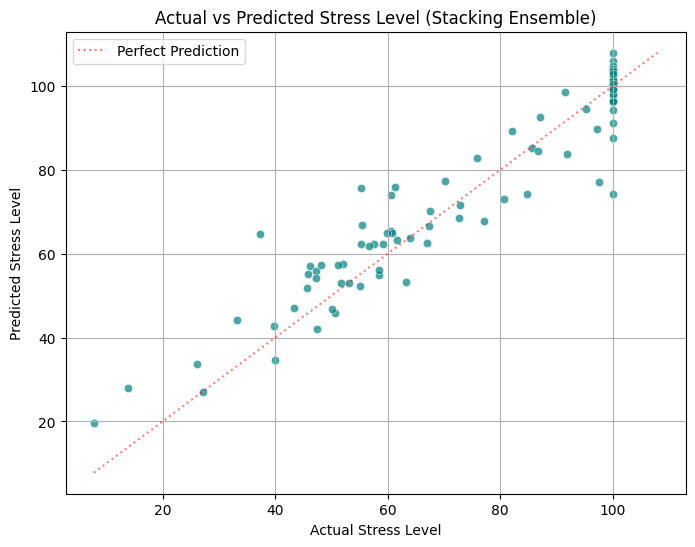

In [75]:
best_model_name = results_df.iloc[0]['Model']
best_model_obj = model_to_train[best_model_name]

# fit the best model
final_pipe = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', best_model_obj)
    ]
)

final_pipe.fit(X_train, y_train)
y_final_pred = final_pipe.predict(X_test)

# plot Actual vs predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_final_pred, alpha=0.7, color='teal')

min_val = min(y_test.min(), y_final_pred.min())
max_val = max(y_test.max(), y_final_pred.max())

plt.plot([min_val, max_val], [min_val, max_val],
         color='red', linestyle='dotted', alpha=0.5, label='Perfect Prediction')

plt.xlabel("Actual Stress Level")
plt.ylabel("Predicted Stress Level")
plt.title(f"Actual vs Predicted Stress Level ({best_model_name})")
plt.legend()
plt.grid()
plt.show()

In [76]:
# 

# Extra task done by me -_

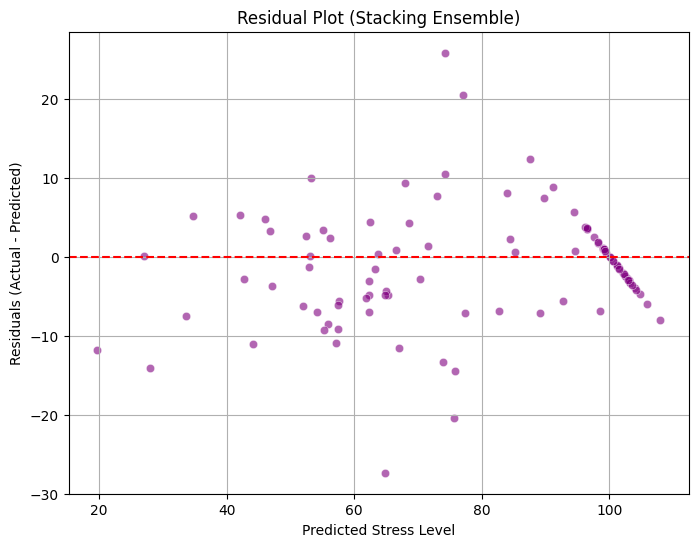

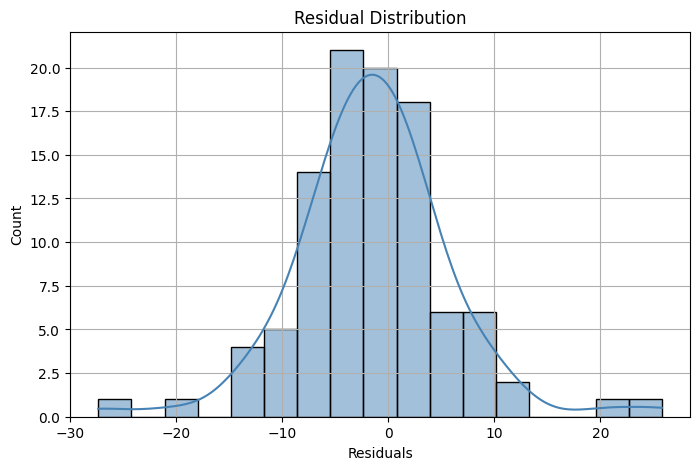

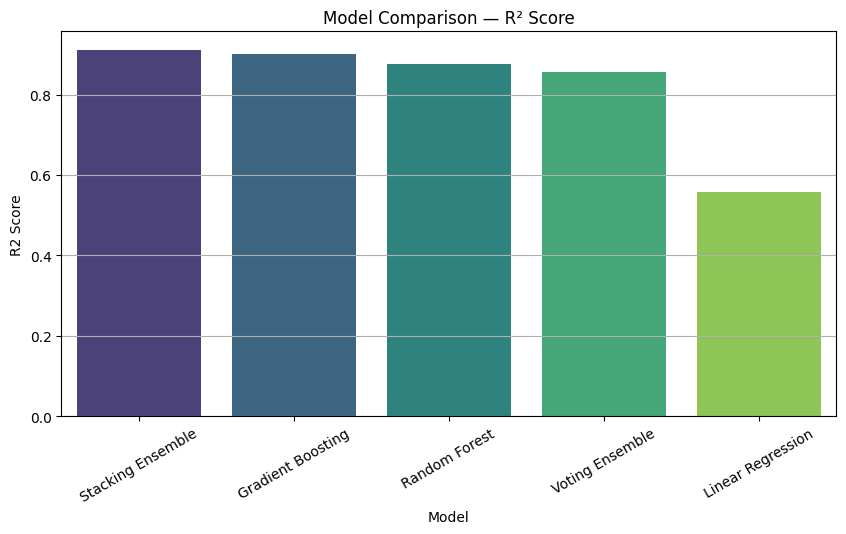

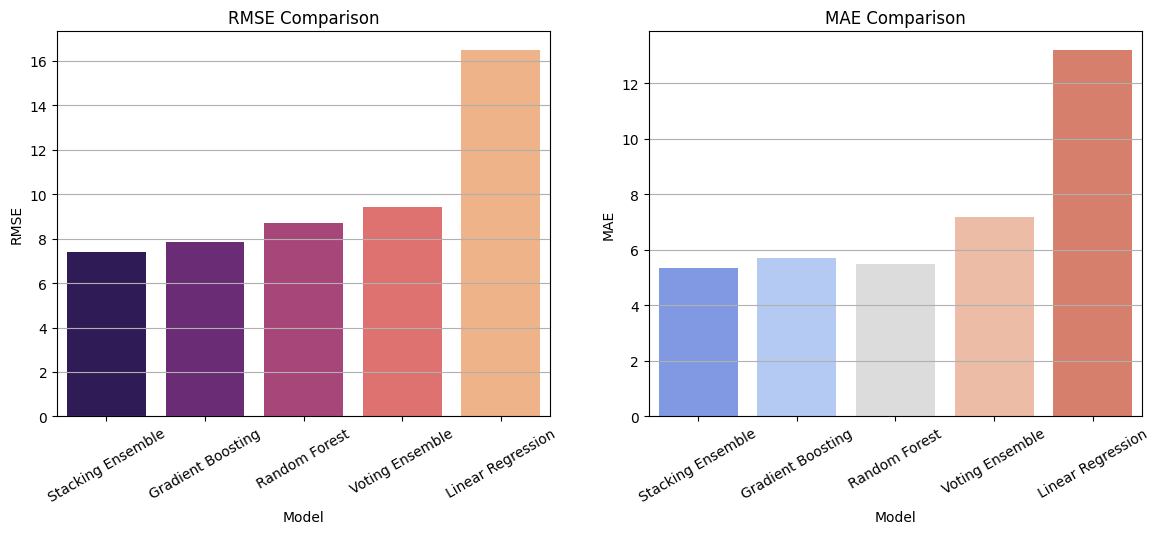

In [79]:
# residuals
residuals = y_test - y_final_pred

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_final_pred, y=residuals, alpha=0.6, color='purple')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Stress Level")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title(f"Residual Plot ({best_model_name})")
plt.grid()
plt.show()

# 

plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, color='steelblue')
plt.xlabel("Residuals")
plt.title("Residual Distribution")
plt.grid()
plt.show()

# 
plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x="Model", y="R2 Score", palette="viridis")
plt.xticks(rotation=30)
plt.title("Model Comparison — R² Score")
plt.grid(axis='y')
plt.show()

# 

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(data=results_df, x="Model", y="RMSE", ax=ax[0], palette="magma")
ax[0].set_title("RMSE Comparison")
ax[0].tick_params(axis='x', rotation=30)

sns.barplot(data=results_df, x="Model", y="MAE", ax=ax[1], palette="coolwarm")
ax[1].set_title("MAE Comparison")
ax[1].tick_params(axis='x', rotation=30)

for a in ax:
    a.grid(axis='y')

plt.show()

# 



In [89]:
# 
feature_names = final_pipe.named_steps['preprocessor'].get_feature_names_out()

# 

model = final_pipe.named_steps['model']

if hasattr(model, "feature_importances_"):
    importances = model.feature_importances_

    feat_imp = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values("Importance", ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=feat_imp.head(15),
                x="Importance", y="Feature", palette="viridis")
    plt.title(f"Top 15 Feature Importances ({best_model_name})")
    plt.show()

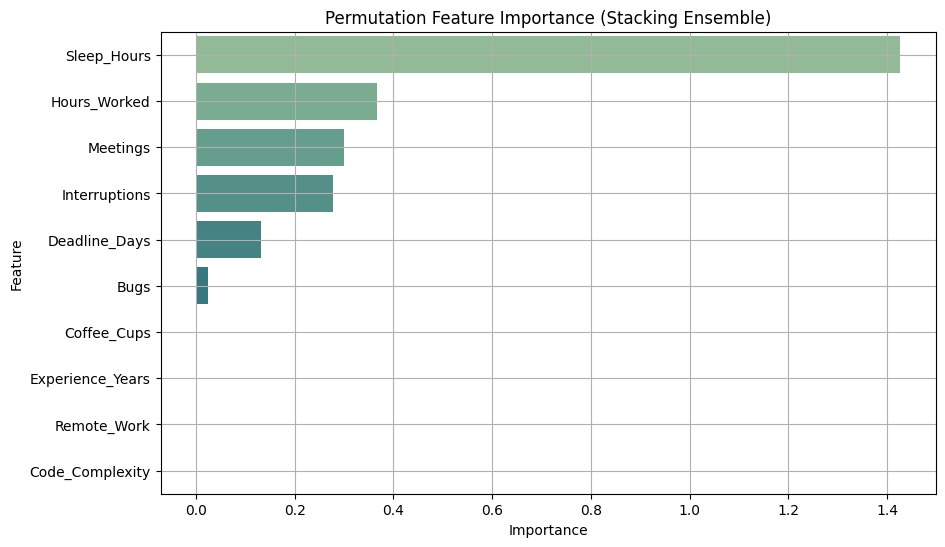

In [87]:
# 
from sklearn.inspection import permutation_importance

feature_names = X_test.columns

from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(
    final_pipe,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

perm_df = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": perm_importance.importances_mean
}).sort_values("Importance", ascending=False)


plt.figure(figsize=(10, 6))
sns.barplot(
    data=perm_df,
    x="Importance",
    y="Feature",
    palette="crest"
)
plt.title(f"Permutation Feature Importance ({best_model_name})")
plt.grid()
plt.show()